In [128]:
import numpy as np
import math
from scipy.stats import norm
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.font_manager import FontProperties

font = FontProperties(fname=r"c:\windows\fonts\simsun.ttc", size=15) #添加字体，显示中文


# 设置基本参数
ttm = 2.0                    # 到期时间，单位年
tSteps = 250                 # 时间方向步数
r = 0.03                     # 无风险利率
d = 0.02                     # 标的股息率
sigma = 0.2                  # 波动率
strike = 100.0               # 期权行权价
spot = 100.0                 # 标的现价
option_style = 'call'        # 看跌期权('put') or 看涨期权('call')

In [129]:
# 二叉树框架（可以通过传入不同的treeTraits类型，设计不同的二叉树结构）
class BinomialTree:
    def __init__(self, spot, riskFree, dividend, tSteps, maturity, sigma, treeTraits):
        self.dt = maturity / tSteps
        self.spot = spot
        self.r = riskFree
        self.d = dividend
        self.tSteps = tSteps
        self.discount = math.exp(-self.r*self.dt)
        self.v = sigma
        self.up = treeTraits.up(self)
        self.down = treeTraits.down(self)
        self.upProbability = treeTraits.upProbability(self)
        self.downProbability = 1.0 - self.upProbability
        self._build_lattice()
        
    def _build_lattice(self):
        '''
        完成构造二叉树的工作   构造一个下三角矩阵
        '''
        self.lattice = np.zeros((self.tSteps+1, self.tSteps+1))
        self.lattice[0][0] = self.spot
        for i in range(self.tSteps):
            for j in range(i+1):
                self.lattice[i+1][j+1] = self.up * self.lattice[i][j]
                self.lattice[i+1][0] = self.down * self.lattice[i][0]
            
    def roll_back(self, payOff):
        '''
        节点计算，并反向倒推
        '''
        for i in range(self.tSteps,0,-1):
            for j in range(i,0,-1):
                if i == self.tSteps:
                    self.lattice[i-1][j-1] = self.discount * (self.upProbability * payOff(self.lattice[i][j]) + self.downProbability * payOff(self.lattice[i][j-1]))
                else:
                    self.lattice[i-1][j-1] = self.discount * (self.upProbability *  self.lattice[i][j] + self.downProbability * self.lattice[i][j-1])

In [130]:
class JarrowRuddTraits:
    @staticmethod
    def up(tree):
        return math.exp((tree.r - tree.d - 0.5*tree.v*tree.v)*tree.dt + tree.v*math.sqrt(tree.dt))
    
    @staticmethod
    def down(tree):
        return math.exp((tree.r - tree.d - 0.5*tree.v*tree.v)*tree.dt - tree.v*math.sqrt(tree.dt))
    
    @staticmethod
    def upProbability(tree):
        return 0.5

In [131]:
class CRRTraits:  
    @staticmethod
    def up(tree):
        return math.exp(tree.v * math.sqrt(tree.dt))
    
    @staticmethod
    def down(tree):
        return math.exp(-tree.v * math.sqrt(tree.dt))
    
    @staticmethod
    def upProbability(tree):
        return 0.5 + 0.5 * (tree.r - tree.d - 0.5 * tree.v*tree.v) * tree.dt / tree.v / math.sqrt(tree.dt)

In [132]:
def pay_off(spot):
    global strike,option_style
    if option_style == 'call':
        return max(spot - strike, 0.0)
    elif option_style == 'put':
        return max(strike - spot, 0.0)
    else:
        print('option_style:call or put')        

In [133]:
testTree = BinomialTree(spot, r, d, tSteps, ttm, sigma, JarrowRuddTraits)
testTree.roll_back(pay_off)
print(u'二叉树价格： %.4f' % testTree.lattice[0][0])

二叉树价格： 11.6860


用BSM模型计算期权价格：

In [135]:
def BSMPrice(option_style, s0, k, r, q, t, sigma):
    s0 = s0 * np.exp(-q*t)
    d1 = (np.log(s0/k) + (r+(sigma**2)/2)*t) / (sigma*(np.sqrt(t)))
    d2 = d1 - sigma*(np.sqrt(t))

    if option_style == 'call':
        value = s0 * norm.cdf(d1) - k * np.exp(-r*t) * norm.cdf(d2)
    elif option_style == 'put':
        value = k * np.exp(-r*t) * norm.cdf(-d2) - s0 * norm.cdf(-d1)
    else:
        print('option_style:call or put')

    return value

prince = BSMPrice(option_style,strike, spot, r, d, ttm, sigma)
print(u'BSM价格： %.4f' %prince)

BSM价格： 11.6761


这里我们想更进一步，用我们现在的算法框架来测试二叉树的收敛性。这里我们用来作比较的算法即为之前描述的 JR二叉树 以及 CRR二叉树：

In [143]:
stepSizes = range(25, 500,25)
jrRes = []
crrRes = []
for tSteps in stepSizes:
    # Jarrow - Rudd 结果
    testTree = BinomialTree(spot, r, d, tSteps, ttm, sigma, JarrowRuddTraits)
    testTree.roll_back(pay_off)
    jrRes.append(testTree.lattice[0][0])
    
    # Cox - Ross - Rubinstein 结果
    testTree = BinomialTree(spot, r, d, tSteps, ttm, sigma, CRRTraits)
    testTree.roll_back(pay_off)
    crrRes.append(testTree.lattice[0][0])

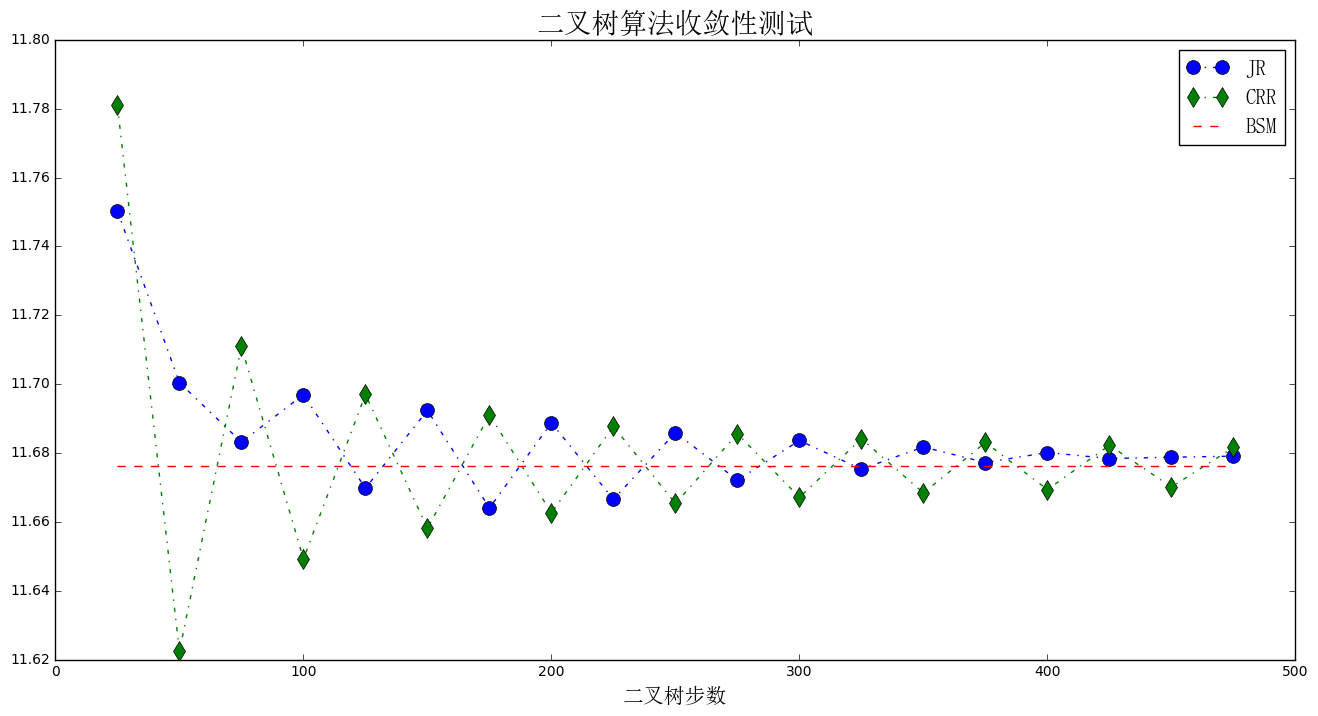

In [144]:
anyRes = [BSMPrice(option_style,strike, spot, r, d, ttm, sigma)] * len(stepSizes)  #len()返回列表元素个数
plt.figure(figsize = (16,8))
plt.plot(stepSizes, jrRes, '-.', marker = 'o', markersize = 10)
plt.plot(stepSizes, crrRes, '-.', marker = 'd', markersize = 10)
plt.plot(stepSizes, anyRes, '--')
plt.legend(['JR', 'CRR', u'BSM'],  prop = font)
plt.xlabel(u'二叉树步数', fontproperties = font)
plt.title(u'二叉树算法收敛性测试', fontproperties = font, fontsize = 20)
plt.show()

我们也可以绘制两种算法的误差随着步长下降的过程。

In [138]:
jrErr = np.array(jrRes) - np.array(anyRes)
crrErr = np.array(crrRes) - np.array(anyRes)
jrErr = np.log(np.abs(jrErr))
crrErr = np.log(np.abs(crrErr))

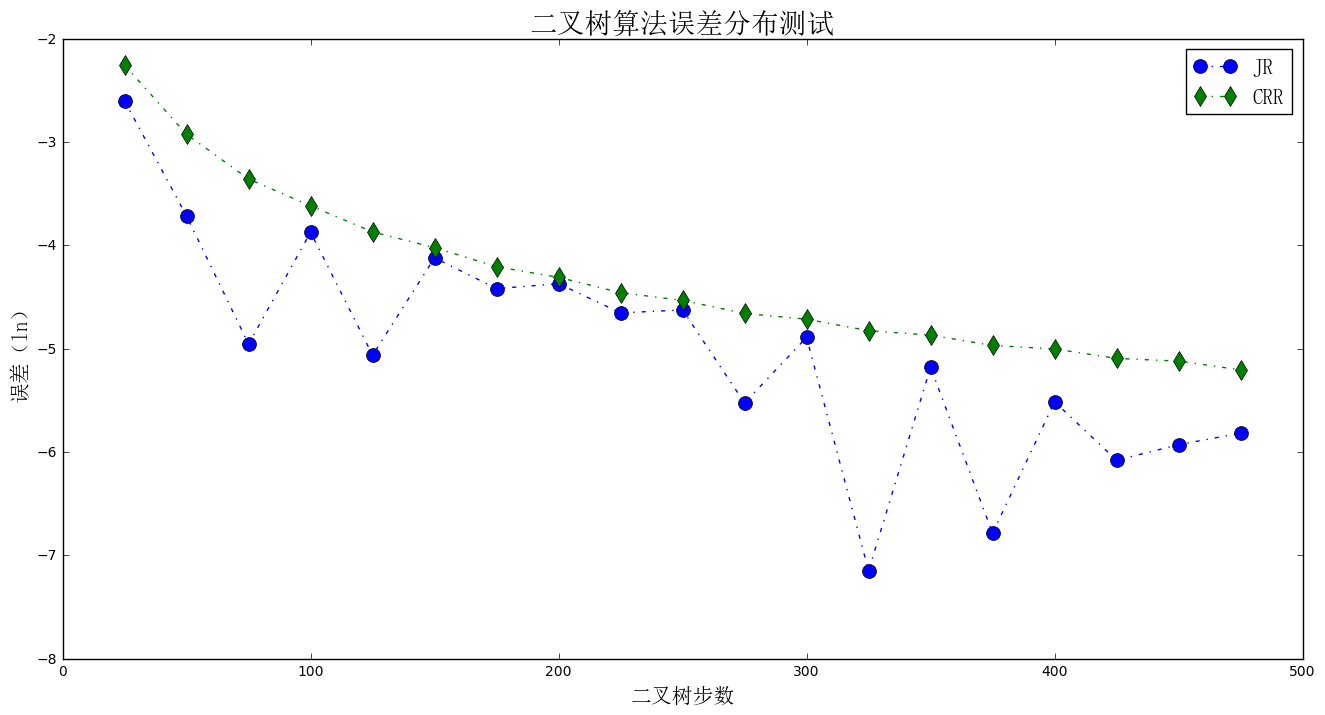

In [139]:
plt.figure(figsize = (16,8))
plt.plot(stepSizes, jrErr, '-.', marker = 'o', markersize = 10)
plt.plot(stepSizes, crrErr, '-.', marker = 'd', markersize = 10)
plt.legend(['JR', 'CRR', u'BSM'],  prop = font)
plt.xlabel(u'二叉树步数', fontproperties = font)
plt.ylabel(u'误差（ln）', fontproperties = font)
plt.title(u'二叉树算法误差分布测试', fontproperties = font, fontsize = 20)
plt.show()

# 美式期权定价

In [140]:
class ExtendBinomialTree(BinomialTree):
    
    def roll_back_american(self, payOff):
        '''
        节点计算，并反向倒推
        '''
        for i in range(self.tSteps,0,-1):
            for j in range(i,0,-1):
                if i == self.tSteps:
                    europeanValue = self.discount * (self.upProbability * payOff(self.lattice[i][j]) + self.downProbability * payOff(self.lattice[i][j-1]))
                else:
                    europeanValue = self.discount * (self.upProbability *  self.lattice[i][j] + self.downProbability * self.lattice[i][j-1])
                # 处理美式行权
                exerciseValue = payOff(self.lattice[i-1][j-1])
                self.lattice[i-1][j-1] = max(europeanValue, exerciseValue)

In [141]:
stepSizes = range(25, 500,25)
jrRes = []
crrRes = []
for tSteps in stepSizes:
    # Jarrow - Rudd 结果
    testTree = ExtendBinomialTree(spot, r, d, tSteps, ttm, sigma, JarrowRuddTraits)
    testTree.roll_back_american(pay_off)
    jrRes.append(testTree.lattice[0][0])
    
    # Cox - Ross - Rubinstein 结果
    testTree = ExtendBinomialTree(spot, r, d, tSteps, ttm, sigma, CRRTraits)
    testTree.roll_back_american(pay_off)
    crrRes.append(testTree.lattice[0][0])

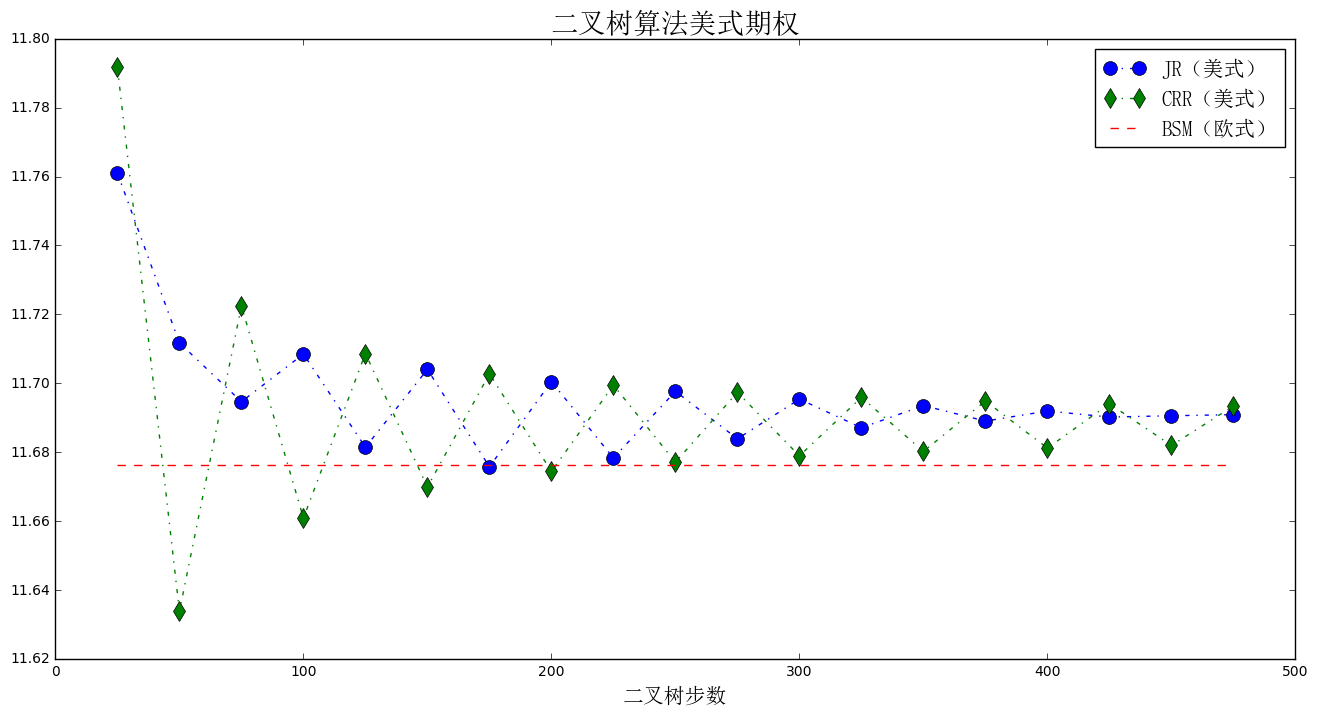

In [142]:
anyRes = [BSMPrice(option_style,strike, spot, r, d, ttm, sigma)] * len(stepSizes)

plt.figure(figsize = (16,8))
plt.plot(stepSizes, jrRes, '-.', marker = 'o', markersize = 10)
plt.plot(stepSizes, crrRes, '-.', marker = 'd', markersize = 10)
plt.plot(stepSizes, anyRes, '--')
plt.legend([u'JR（美式）', u'CRR（美式）', u'BSM（欧式）'], prop = font)
plt.xlabel(u'二叉树步数', fontproperties = font)
plt.title(u'二叉树算法美式期权', fontproperties = font, fontsize = 20)
plt.show()